# このNotebookについて

このNotebookでは、PlanckThermometerで行われる温度計算処理の開発(と簡単なテスト)を行います。

# 事前処理

In [2]:
# 外部ライブラリのimport
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.constants import h, c, k  # プランク定数, 光速, ボルツマン定数
from scipy.optimize import curve_fit

In [3]:
# 自作ライブラリのimport

# ファイル読み込み
from modules.file_format.spe_wrapper import SpeWrapper
from modules.file_format.lightfield_csv_wrapper import LightfieldCsv
# データ処理
from modules.data_model.raw_spectrum_data import RawSpectrumData
# Fittingクラス
# 図を作る処理を書いたクラス
# しきい値を決定するときに使うクラス


# テストデータの読み込み

## 参照スペクトルデータ

In [4]:
# 参照スペクトルデータ

path_to_ref_spectrum = "/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/2024_0403/OL245C.csv"

ref_spectrum = pd.read_csv(
    path_to_ref_spectrum,
    header=None,
    names=["wavelength", "intensity"]
)

## データセット1

In [5]:
# 元の露光データ
path_to_raw_radiation_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/rotated_OIbDia08_4.spe'

# 上流・下流のフィルター補正値
path_to_up_filter_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/2024_0403/Standard/6_Up_std.spe'
path_to_down_filter_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/2024_0403/Standard/6-Down_std.spe'

# 較正後スペクトルデータ
path_to_calibrated_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/rotated_OIbDia08_4_calib.csv'

# 温度分布データ
path_to_dist_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/rotated_OIbDia08_4_dist(30).csv'

In [6]:
# インスタンス化

# 露光データ
raw_spe_1 = SpeWrapper(path_to_raw_radiation_1)
raw_radiation_1 = RawSpectrumData(raw_spe_1)
# フィルター
up_1 = SpeWrapper(path_to_up_filter_1)
down_1 = SpeWrapper(path_to_down_filter_1)
# 校正後のスペクトルデータ
ans_calib_1 = LightfieldCsv(path_to_calibrated_1, 'calib')
ans_calib_1.set_calib_pixel(
    position_pixel_num=raw_radiation_1.position_pixel_num,
    wavelength_pixel_num=raw_radiation_1.wavelength_pixel_num
)
# 計算された温度データ
ans_dist_1 = LightfieldCsv(path_to_dist_1, 'dist')
ans_dist_1.set_dist_pixel(position_pixel_num=raw_radiation_1.position_pixel_num)

In [7]:
# filterデータを確認
print(up_1.get_all_data_arr().shape)
print(up_1.get_frame_data(frame=0).shape)
up_1.get_all_data_arr()

(1, 1, 512)
(1, 512)


array([[[ 1.057000e+03,  1.170000e+03,  1.341000e+03,  1.525000e+03,
          1.555000e+03,  2.304000e+03,  2.770000e+03,  1.992000e+03,
          2.177000e+03,  3.126000e+03,  1.894000e+03,  2.957000e+03,
          3.190000e+03,  2.768000e+03,  3.702000e+03,  3.359000e+03,
          4.272000e+03,  4.032000e+03,  5.251000e+03,  4.887000e+03,
          4.545000e+03,  5.563000e+03,  5.844000e+03,  6.660000e+03,
          6.505000e+03,  6.883000e+03,  7.899000e+03,  8.029000e+03,
          7.316000e+03,  7.688000e+03,  7.977000e+03,  8.109000e+03,
          8.856000e+03,  9.873000e+03,  1.100500e+04,  1.179000e+04,
          1.244100e+04,  1.372400e+04,  1.404500e+04,  1.487100e+04,
          1.542000e+04,  1.526200e+04,  1.670000e+04,  1.726400e+04,
          1.932100e+04,  2.095500e+04,  2.103000e+04,  2.332700e+04,
          2.480800e+04,  2.493500e+04,  2.545600e+04,  2.468100e+04,
          2.584600e+04,  2.722900e+04,  2.861300e+04,  3.042900e+04,
          3.312600e+04,  3.586700e

In [8]:
wavelength_arr = down_1.get_wavelengths()[0]
wavelength_arr

array([438.33080966, 439.35941323, 440.38799824, 441.41656467,
       442.44511251, 443.47364176, 444.50215241, 445.53064444,
       446.55911786, 447.58757265, 448.6160088 , 449.6444263 ,
       450.67282515, 451.70120534, 452.72956686, 453.75790969,
       454.78623384, 455.81453929, 456.84282604, 457.87109407,
       458.89934337, 459.92757395, 460.95578579, 461.98397887,
       463.0121532 , 464.04030877, 465.06844556, 466.09656356,
       467.12466278, 468.15274319, 469.1808048 , 470.20884759,
       471.23687155, 472.26487668, 473.29286296, 474.3208304 ,
       475.34877897, 476.37670867, 477.4046195 , 478.43251144,
       479.46038448, 480.48823863, 481.51607386, 482.54389017,
       483.57168755, 484.59946599, 485.62722549, 486.65496603,
       487.68268761, 488.71039022, 489.73807385, 490.76573848,
       491.79338413, 492.82101076, 493.84861838, 494.87620698,
       495.90377654, 496.93132707, 497.95885854, 498.98637096,
       500.01386431, 501.04133859, 502.06879378, 503.09

In [9]:
raw_spe_1.get_wavelengths()

[array([438.33080966, 439.35941323, 440.38799824, 441.41656467,
        442.44511251, 443.47364176, 444.50215241, 445.53064444,
        446.55911786, 447.58757265, 448.6160088 , 449.6444263 ,
        450.67282515, 451.70120534, 452.72956686, 453.75790969,
        454.78623384, 455.81453929, 456.84282604, 457.87109407,
        458.89934337, 459.92757395, 460.95578579, 461.98397887,
        463.0121532 , 464.04030877, 465.06844556, 466.09656356,
        467.12466278, 468.15274319, 469.1808048 , 470.20884759,
        471.23687155, 472.26487668, 473.29286296, 474.3208304 ,
        475.34877897, 476.37670867, 477.4046195 , 478.43251144,
        479.46038448, 480.48823863, 481.51607386, 482.54389017,
        483.57168755, 484.59946599, 485.62722549, 486.65496603,
        487.68268761, 488.71039022, 489.73807385, 490.76573848,
        491.79338413, 492.82101076, 493.84861838, 494.87620698,
        495.90377654, 496.93132707, 497.95885854, 498.98637096,
        500.01386431, 501.04133859, 502.

In [10]:
# csvの形式を確認するための簡易読み込み
calib = pd.read_csv(
    path_to_calibrated_1,
    skiprows=0,
    nrows=300000 # この行数だけ読み込み
)

dist = pd.read_csv(
    path_to_dist_1,
    header=0
)

In [11]:
# 表示
calib

,ROI,Frame,Row,Column,Wavelength,Intensity
0,1,1,0,0,438.330810,0.000000
1,1,1,0,1,439.359413,0.000000
2,1,1,0,2,440.387998,0.000000
3,1,1,0,3,441.416565,0.000000
4,1,1,0,4,442.445113,0.000000
...,...,...,...,...,...,...
299995,1,2,73,475,924.675787,0.014308
299996,1,2,73,476,925.694613,0.051501
299997,1,2,73,477,926.713417,-0.008876
299998,1,2,73,478,927.732198,0.006163


In [12]:
# 表示
dist

,ROI,Frame,Row,Column,Wavelength,Intensity
0,1,1,0,0,NaN,0.000000
1,1,1,0,1,NaN,3210.848145
2,1,1,0,2,NaN,4495.838379
3,1,1,0,3,NaN,3135.152344
4,1,1,0,4,NaN,3427.057617
...,...,...,...,...,...,...
409595,1,1,799,507,NaN,5799.083496
409596,1,1,799,508,NaN,5004.921387
409597,1,1,799,509,NaN,4429.046387
409598,1,1,799,510,NaN,3776.591064


In [13]:
# headerを表示
calib.columns

Index(['ROI', 'Frame', 'Row', 'Column', 'Wavelength', 'Intensity'], dtype='object')

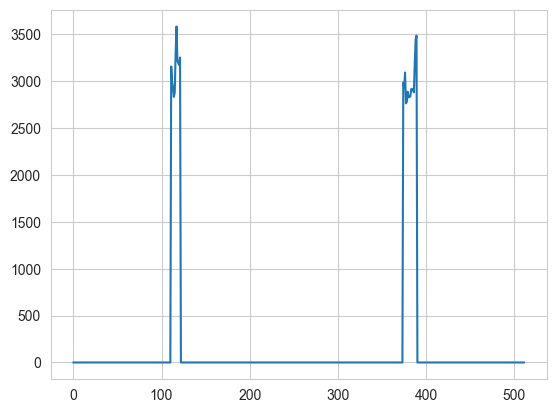

In [14]:
# dist.csvのデータをきちんと得られているかplotして確認
plt.plot(ans_dist_1.get_frame_temperature(frame=300))

## データセット2

In [15]:
# TODO: まだやってません

# 元の露光データ


# 上流・下流のフィルター補正値


# 較正後スペクトルデータ


# 温度分布データ



## データを辞書にまとめる

In [16]:
# TODO: まだやってません

# 辞書に格納
test_data_dict = {
    
}

# データセット1の適当なフレームで再現

## 露光データの俯瞰

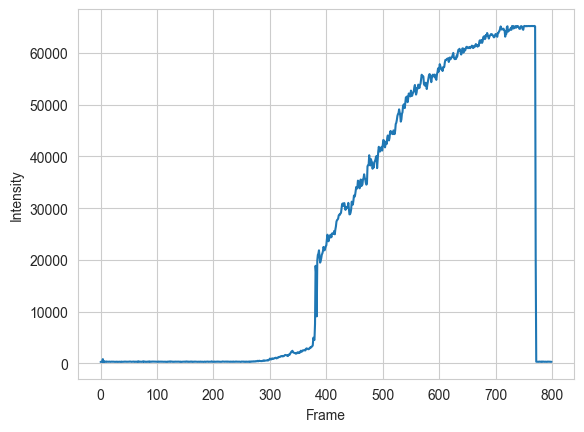

In [17]:
# 最大強度配列を可視化
plt.plot(raw_radiation_1.get_max_intensity_arr())
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.show()
plt.close()

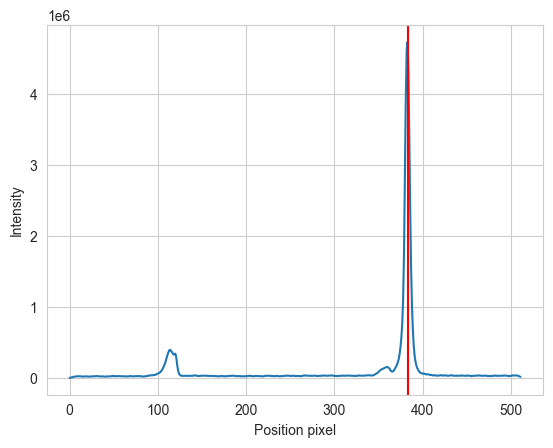

In [18]:
# 露光データ
plt.plot(raw_radiation_1.get_frame_data(400).sum(axis=1)) # 500 frame目の、位置ピクセルから見た積算データ
plt.axvline(383, color='red') # ここらへんを採用しようかなという目安
plt.xlabel('Position pixel')
plt.ylabel('Intensity')
plt.show()
plt.close()

## frame, positonを設定

In [19]:
# test frameを設定
test_frame = 400

# test positionを設定
test_position = 383 # →必要なフィルターデータはdown (> 255なので)

In [20]:
# LightFieldで校正されたスペクトルデータを取得(calib.csvより)
# データが大きいのでロードが長い(csv内でのskipには時間がかかると思われる)。石澤のラップトップで80 secほど
ans_spectrum = ans_calib_1.get_spectrum(frame=test_frame, position_pixel=test_position)

In [21]:
# 表示して確認
ans_spectrum

,Wavelength,Intensity
0,438.330810,0.000000
1,439.359413,0.000000
2,440.387998,0.086215
3,441.416565,0.056397
4,442.445113,0.085750
...,...,...
507,957.266983,-0.116481
508,958.285083,48.569248
509,959.303159,0.000000
510,960.321213,2.681862


In [22]:
# 配列に格納する
raw_spectrum = raw_radiation_1.get_frame_data(test_frame)[test_position]
ref_intensity = ref_spectrum['intensity']
down_1_intensity = down_1.get_all_data_arr()[0][0] # downのfilterデータ

In [23]:
# NumPy の補間関数を使用して、ランプデータのデータ点の波長を揃える
ref_intensity_interpolated = np.interp(wavelength_arr, ref_spectrum['wavelength'], ref_spectrum['intensity'])

Text(0, 0.5, 'Intensity')

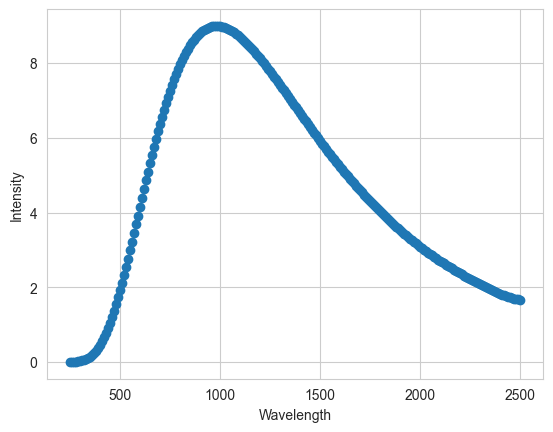

In [24]:
# ランプデータの視覚化(補間前)
plt.scatter(ref_spectrum['wavelength'], ref_spectrum['intensity'])
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

Text(0, 0.5, 'Intensity')

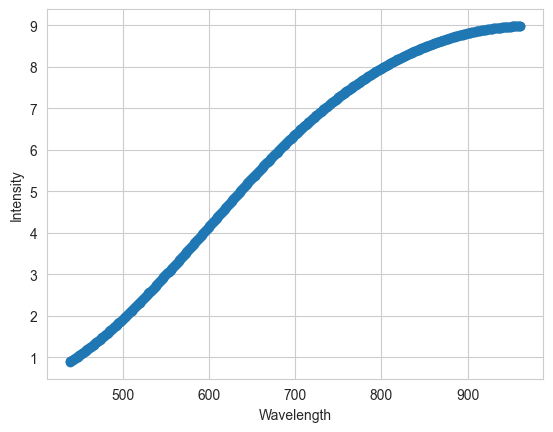

In [25]:
# 補間後のランプデータ
# speのwavelengthに対応する強度配列になっていることを確認
plt.scatter(wavelength_arr, ref_intensity_interpolated)
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

In [26]:
# なんとなく確認
ref_spectrum

,wavelength,intensity
0,250,0.002029
1,260,0.003804
2,270,0.006722
3,280,0.011210
4,290,0.017890
...,...,...
221,2460,1.712184
222,2470,1.697810
223,2480,1.684788
224,2490,1.673168


In [27]:
ref_intensity / raw_spectrum # →ここでエラーがでたので、↑補間した。このエラーは理解のために残している

ValueError: operands could not be broadcast together with shapes (226,) (512,) 

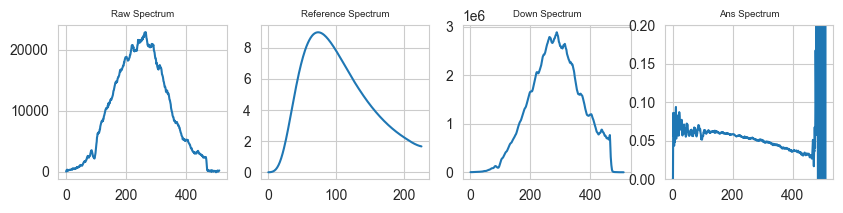

In [28]:
# 一通りのデータを可視化して確認
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

axes[0].plot(raw_spectrum)
axes[0].set_title('Raw Spectrum', fontsize='x-small')
axes[1].plot(ref_intensity)
axes[1].set_title('Reference Spectrum', fontsize='x-small')
axes[2].plot(down_1_intensity)
axes[2].set_title('Down Spectrum', fontsize='x-small')
axes[3].plot(ans_spectrum['Intensity'])
axes[3].set_title('Ans Spectrum', fontsize='x-small')
axes[3].set_ylim(0, 0.2)

plt.show()
plt.close()

## 補正

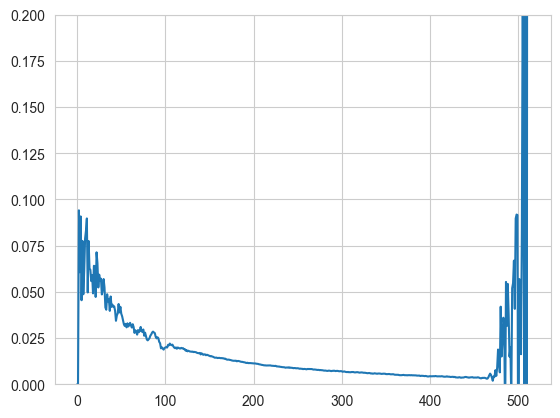

In [29]:
# フィルター補正
plt.plot(raw_spectrum / down_1_intensity) # 生 / filter

plt.ylim(0, 0.2)
plt.show()
plt.close()

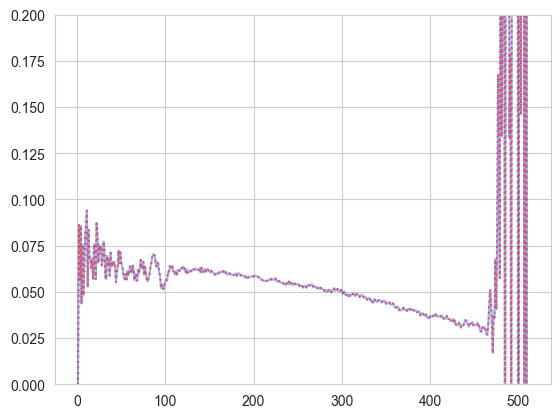

In [96]:
# 計算してcalib.csvの該当データと一致することを確認
plt.plot(ref_intensity_interpolated * raw_spectrum / down_1_intensity, color='royalblue', alpha=0.5) # ランプ * 生 / filter
plt.plot(ans_spectrum['Intensity'], color='red', alpha=0.5, linestyle=':')

plt.ylim(0, 0.2)
plt.show()
plt.close()


In [31]:
# 変数に入れておく
calculated_spectrum = ref_intensity_interpolated * raw_spectrum / down_1_intensity

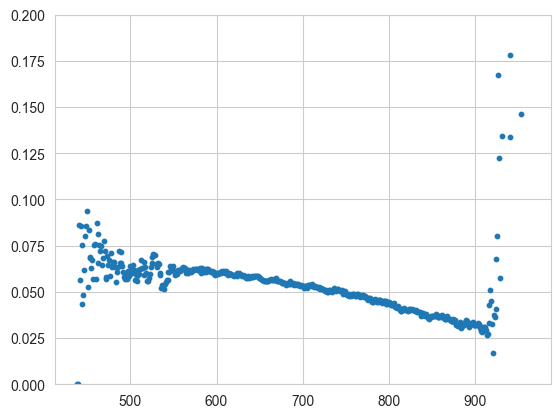

In [32]:
# 不要な視覚化
plt.scatter(wavelength_arr, calculated_spectrum, s=10)
plt.ylim(0, 0.2)
plt.show()
plt.close()

## 温度の計算

### プランク関数によるfitting

In [33]:
# PlanckThermometerの結果の温度を取得。これがゴール
ans_dist_1.get_frame_temperature(test_frame)[test_position]

np.float64(5422.6259765625)

In [34]:
# プランク関数の定義
def planck_function(wavelength, T, A):
    """
    wavelength: 波長 (nm単位), T: 温度 (K), A: スケール因子
    """
    wavelength_m = wavelength * 1e-9  # nm -> m
    intensity = (2 * h * c**2) / (wavelength_m**5) * (1 / (np.exp((h * c) / (wavelength_m * k * T)) - 1))
    return A * intensity


In [35]:
# 波長範囲を 600-800 nm に制限
mask = (wavelength_arr >= 600) & (wavelength_arr <= 800) # boolean配列が作成される
wavelength_fit = wavelength_arr[mask] # boolean配列を入れてあげると、trueのところだけ抽出できる
intensity_fit = calculated_spectrum[mask]

# フィッティング実行
initial_temperature = 3000  # 初期温度を 3000 K に設定
initial_scale = 1e-6        # 初期スケール因子を適当に設定
params, covariance = curve_fit(planck_function, wavelength_fit, intensity_fit, p0=[initial_temperature, initial_scale])

# フィッティング結果と標準誤差
fitted_temperature, fitted_scale = params
temperature_error, scale_error = np.sqrt(np.diag(covariance))

print(f"フィッティングされた温度: {fitted_temperature:.2f} K ± {temperature_error:.2f} K")
print(f"フィッティングされたスケール因子: {fitted_scale:.2e} ± {scale_error:.2e}")


フィッティングされた温度: 5422.89 K ± 17.38 K
フィッティングされたスケール因子: 3.26e-15 ± 4.15e-17


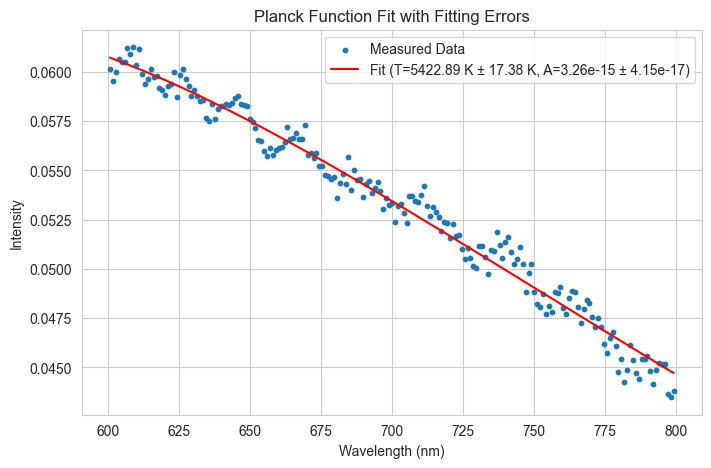

In [36]:

# フィッティング結果のプロット
plt.figure(figsize=(8, 5))
plt.scatter(wavelength_fit, intensity_fit, label='Measured Data', s=10)
plt.plot(wavelength_fit, planck_function(wavelength_fit, fitted_temperature, fitted_scale), 'r-', label=f'Fit (T={fitted_temperature:.2f} K ± {temperature_error:.2f} K, A={fitted_scale:.2e} ± {scale_error:.2e})')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Planck Function Fit with Fitting Errors')
plt.grid(True)
plt.show()


### 二色法による計算

In [37]:
# 使用するデータを再度確認しておく
print(pd.DataFrame(wavelength_fit, intensity_fit))

                   0
0.060138  600.614340
0.059526  601.639904
0.059997  602.665447
0.060639  603.690971
0.060478  604.716475
...              ...
0.045167  795.104204
0.045183  796.125831
0.043638  797.147436
0.043486  798.169019
0.043796  799.190582

[195 rows x 1 columns]


In [38]:
from scipy.optimize import fsolve # FIXME: 最初にまとめる

# NOTE: それっぽい値は出るが、合ってるか確認がほしい
# 二色法で温度を求める関数を定義
def equation_to_solve(T, lambda1, lambda2, R):
    """
    強度比 R の式から温度を求めるための方程式
    二色法でググってください
    
    Parameters:
    ----------
    T : float
        温度 (K)
    lambda1 : float
        波長1 (nm)
    lambda2 : float
        波長2 (nm)
    R : float
        強度比 R = I(lambda1) / I(lambda2)
    
    Returns:
    -------
    difference : float
        左辺と右辺の差（ゼロに近い値を探す）
    """
    # 波長をメートル単位に変換
    lambda1_m = lambda1 * 1e-9
    lambda2_m = lambda2 * 1e-9

    # 分子と分母を計算
    numerator = lambda2_m**5 * (np.exp(h * c / (lambda2_m * k * T)) - 1)
    denominator = lambda1_m**5 * (np.exp(h * c / (lambda1_m * k * T)) - 1)

    # 強度比を計算
    R_calculated = numerator / denominator

    # 左辺と右辺の差を返す
    return R_calculated - R


def calculate_temperature_all_pairs(wavelength_fit, intensity_fit):
    """
    波長の大小関係を満たすすべてのペアに対して温度を数値的に解き、警告が発生したペアを記録
    
    Parameters:
    ----------
    wavelength_fit : ndarray
        波長の配列（nm単位）
    intensity_fit : ndarray
        強度の配列
    
    Returns:
    -------
    temperatures : list of floats
        各ペアに対応する温度のリスト
    warning_pairs : list of tuples
        警告が発生した波長ペアのリスト
    """
    temperatures = []
    warning_pairs = []  # 警告が発生したペアを記録
    n = len(wavelength_fit)

    for i in range(n):
        for j in range(i + 1, n):
            lambda1 = wavelength_fit[i]
            lambda2 = wavelength_fit[j]
            I1 = intensity_fit[i]
            I2 = intensity_fit[j]

            # 強度比 R を計算
            R = I1 / I2

            # 初期値を仮定
            T_initial_guess = 6000  # K

            # 警告をキャッチしながら数値解を求める
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")  # すべての警告をキャッチ

                try:
                    T_solution = fsolve(equation_to_solve, T_initial_guess, args=(lambda1, lambda2, R))[0]
                    temperatures.append(T_solution)

                    # 警告が発生した場合、そのペアを記録
                    if w:
                        warning_pairs.append((lambda1, lambda2))

                except Exception as e:
                    # 例外が発生した場合もペアを記録
                    warning_pairs.append((lambda1, lambda2))

    return np.array(temperatures), warning_pairs

def plot_warning_pairs(warning_pairs):
    """
    警告が発生した波長ペアを散布図で可視化する
    
    Parameters:
    ----------
    warning_pairs : list of tuples
        警告が発生した波長ペアのリスト [(lambda1, lambda2), ...]
    """
    if not warning_pairs:
        print("警告が発生したペアはありません。")
        return
    
    # 警告ペアの波長を抽出
    lambda1_vals, lambda2_vals = zip(*warning_pairs)
    
    # 散布図を作成
    plt.figure(figsize=(8, 6))
    plt.scatter(lambda1_vals, lambda2_vals, c='red', alpha=0.6, edgecolor='black')
    plt.xlabel("Wavelength 1 (nm)")
    plt.ylabel("Wavelength 2 (nm)")
    plt.title("Warning Pairs Scatter Plot")
    plt.grid(True)
    plt.show()

def plot_warning_heatmap(warning_pairs, bin_size=10):
    """
    警告が発生した波長ペアをヒートマップで可視化
    
    Parameters:
    ----------
    warning_pairs : list of tuples
        警告が発生した波長ペアのリスト [(lambda1, lambda2), ...]
    bin_size : int
        波長を区切るビンのサイズ
    """
    if not warning_pairs:
        print("警告が発生したペアはありません。")
        return
    
    # 波長範囲を取得
    lambda1_vals, lambda2_vals = zip(*warning_pairs)
    lambda_min = int(min(min(lambda1_vals), min(lambda2_vals)))
    lambda_max = int(max(max(lambda1_vals), max(lambda2_vals)))
    
    # 波長をビンに分けてヒートマップの行列を作成
    bins = np.arange(lambda_min, lambda_max + bin_size, bin_size)
    heatmap, xedges, yedges = np.histogram2d(lambda1_vals, lambda2_vals, bins=(bins, bins))
    
    # ヒートマップをプロット
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap.T, cmap='Reds', cbar=True, xticklabels=bins, yticklabels=bins)
    plt.xlabel("Wavelength 1 (nm)")
    plt.ylabel("Wavelength 2 (nm)")
    plt.title("Warning Pairs Heatmap")
    plt.show()

In [39]:
# 温度を計算
temperatures, warning_pairs = calculate_temperature_all_pairs(wavelength_fit, intensity_fit)
temperatures = temperatures[
    (temperatures > 1_000) & (temperatures < 10_000)
]

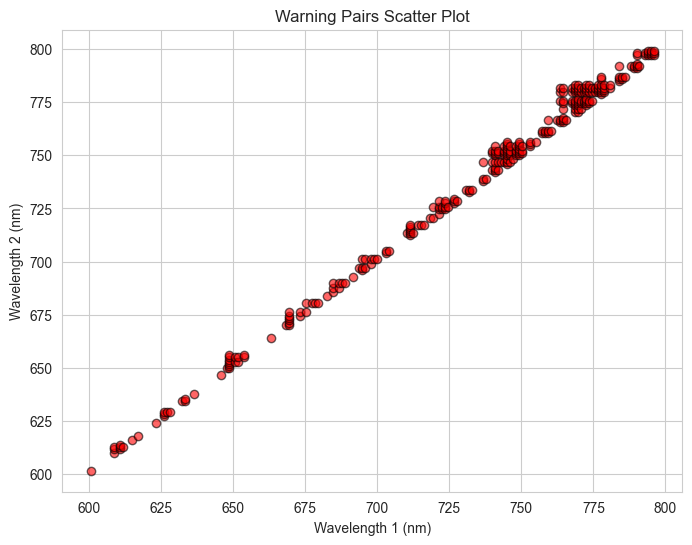

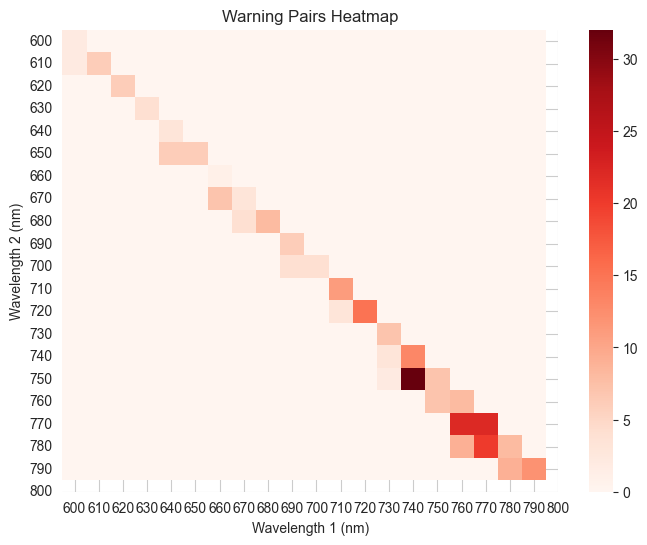

In [40]:
# 計算できなかった波長ペアを視覚化
# だいたい近すぎるペアはエラーが出る。かなりいい相関が出るはず
plot_warning_pairs(warning_pairs)
plot_warning_heatmap(warning_pairs)
plt.show()
plt.close()

(array([2.44385612e-06, 3.97126619e-06, 2.74933813e-06, 6.10964030e-06,
        4.88771224e-06, 5.19319425e-06, 4.27674821e-06, 5.80415828e-06,
        7.94253239e-06, 1.19137986e-05, 1.49686187e-05, 1.31357266e-05,
        2.01618130e-05, 2.44385612e-05, 2.62714533e-05, 3.81852519e-05,
        3.02427195e-05, 3.51304317e-05, 5.62086908e-05, 7.97308059e-05,
        1.24942144e-04, 2.30638921e-04, 4.59139468e-04, 9.43328462e-04,
        1.26530651e-03, 9.04532246e-04, 4.22481627e-04, 1.98868792e-04,
        1.38077871e-04, 9.59213527e-05, 7.08718275e-05, 5.43757987e-05,
        3.66578418e-05, 2.77988634e-05, 3.08536835e-05, 2.10782590e-05,
        2.19947051e-05, 1.74124749e-05, 1.77179569e-05, 1.34412087e-05,
        1.31357266e-05, 1.00809065e-05, 8.24801440e-06, 1.22192806e-05,
        6.10964030e-06, 8.55349642e-06, 7.94253239e-06, 4.88771224e-06,
        5.80415828e-06, 3.36030216e-06]),
 array([1017.31944629, 1196.86722694, 1376.41500759, 1555.96278824,
        1735.51056889, 191

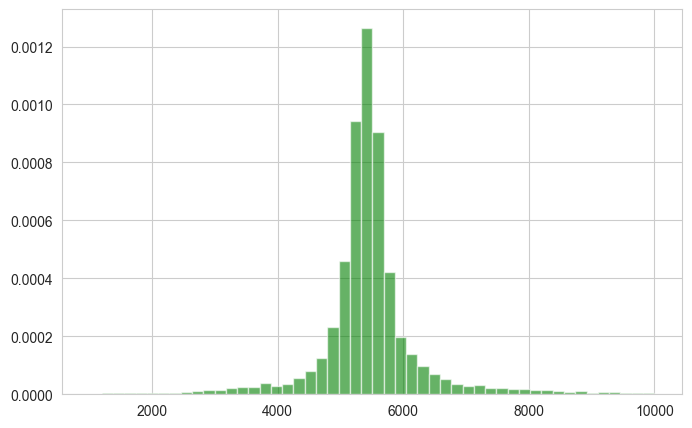

In [41]:

# 計算された温度のヒストグラムを作成
plt.figure(figsize=(8, 5))
plt.hist(temperatures, bins=50, density=True, alpha=0.6, color='g', label='Temperature Histogram')


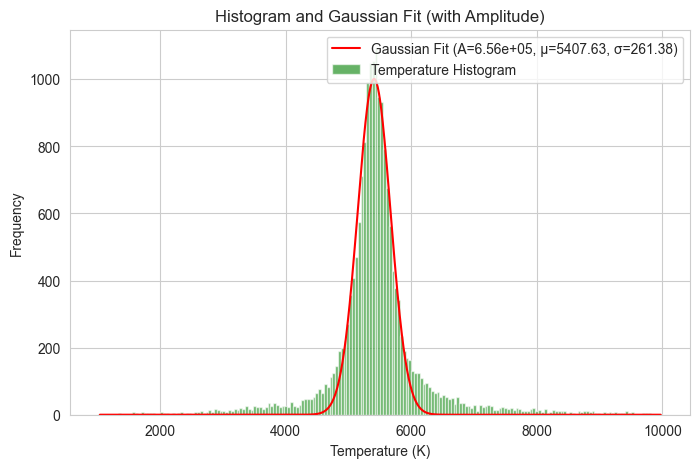

In [42]:
# ヒストグラムをfittingする関数を定義。ガウシアン、ローレンチアン、それらの和などを試している

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# ガウシアン関数の定義（振幅 A、平均 mu、標準偏差 sigma を含む）
def gaussian(x, A, mu, sigma):
    """
    ガウシアン（正規分布）関数
    Parameters:
    ----------
    x : array-like
        独立変数（温度）
    A : float
        スケール係数（振幅）
    mu : float
        ガウシアンの平均
    sigma : float
        ガウシアンの標準偏差
    
    Returns:
    -------
    y : array-like
        ガウシアン関数の値
    """
    return A * norm.pdf(x, mu, sigma)

# ヒストグラムを作成（温度データを使用）
hist_values, bin_edges = np.histogram(temperatures, bins=200)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 初期値を仮定してフィッティングを実行
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[max(hist_values), np.mean(temperatures), np.std(temperatures)])

# フィット結果のパラメータ
A_fit, mu_fit, sigma_fit = popt

# フィットしたガウシアンを計算
x = np.linspace(min(bin_centers), max(bin_centers), 1000)
y_fit = gaussian(x, A_fit, mu_fit, sigma_fit)

# ヒストグラムとガウシアンフィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x, y_fit, 'r-', label=f'Gaussian Fit (A={A_fit:.2e}, μ={mu_fit:.2f}, σ={sigma_fit:.2f})')

# ラベル・タイトル
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Gaussian Fit (with Amplitude)')
plt.legend()
plt.show()


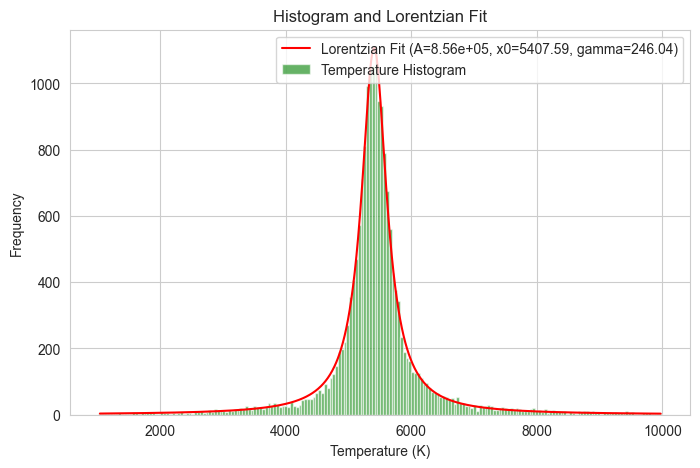

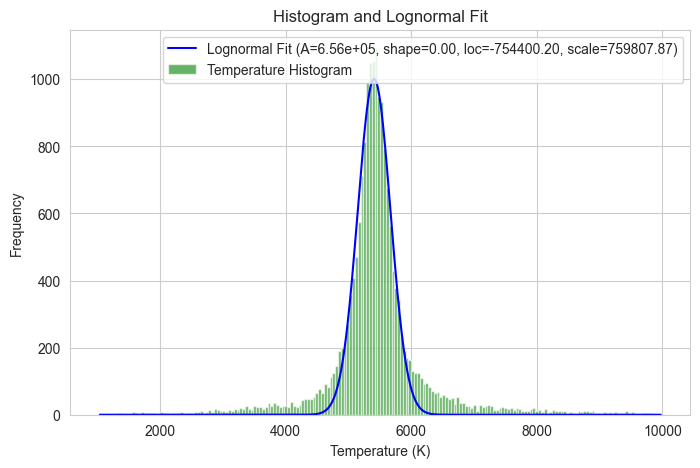

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy, lognorm
from scipy.optimize import curve_fit

# --- 1. ローレンツ分布（Cauchy分布）のフィッティング --- #
def lorentzian(x, A, x0, gamma):
    """
    ローレンツ分布（Cauchy分布）のPDF
    A : 振幅、x0 : 中心、gamma : 幅
    """
    return A * cauchy.pdf(x, loc=x0, scale=gamma)

# ヒストグラムを作成
hist_values, bin_edges = np.histogram(temperatures, bins=200)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ローレンツ分布のフィッティング
popt_lorentz, pcov_lorentz = curve_fit(lorentzian, bin_centers, hist_values, p0=[max(hist_values), np.mean(temperatures), 100])

# フィット結果のパラメータ
A_lorentz, x0_lorentz, gamma_lorentz = popt_lorentz

# フィットしたローレンツ分布を計算
x = np.linspace(min(bin_centers), max(bin_centers), 1000)
y_lorentz = lorentzian(x, A_lorentz, x0_lorentz, gamma_lorentz)

# ヒストグラムとローレンツフィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x, y_lorentz, 'r-', label=f'Lorentzian Fit (A={A_lorentz:.2e}, x0={x0_lorentz:.2f}, gamma={gamma_lorentz:.2f})')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Lorentzian Fit')
plt.legend()
plt.show()

# --- 2. 対数正規分布（Lognormal分布）のフィッティング --- #
def lognormal(x, A, shape, loc, scale):
    """
    対数正規分布のPDF
    A : 振幅、shape : 形状、loc : 位置、scale : スケール
    """
    return A * lognorm.pdf(x, shape, loc=loc, scale=scale)

# 対数正規分布のフィッティング（maxfev を増加）
popt_lognorm, pcov_lognorm = curve_fit(lognormal, bin_centers, hist_values, p0=[max(hist_values), 0.5, 0, np.mean(temperatures)], maxfev=20000)

# フィット結果のパラメータ
A_lognorm, shape_lognorm, loc_lognorm, scale_lognorm = popt_lognorm

# フィットした対数正規分布を計算
y_lognorm = lognormal(x, A_lognorm, shape_lognorm, loc_lognorm, scale_lognorm)

# ヒストグラムと対数正規分布フィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x, y_lognorm, 'b-', label=f'Lognormal Fit (A={A_lognorm:.2e}, shape={shape_lognorm:.2f}, loc={loc_lognorm:.2f}, scale={scale_lognorm:.2f})')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Lognormal Fit')
plt.legend()
plt.show()


Gaussian: A1=9.47e+05, mu1=5406.29, sigma1=197.36
Lorentzian: A2=2.43e+06, mu2=5412.05, gamma2=347.51


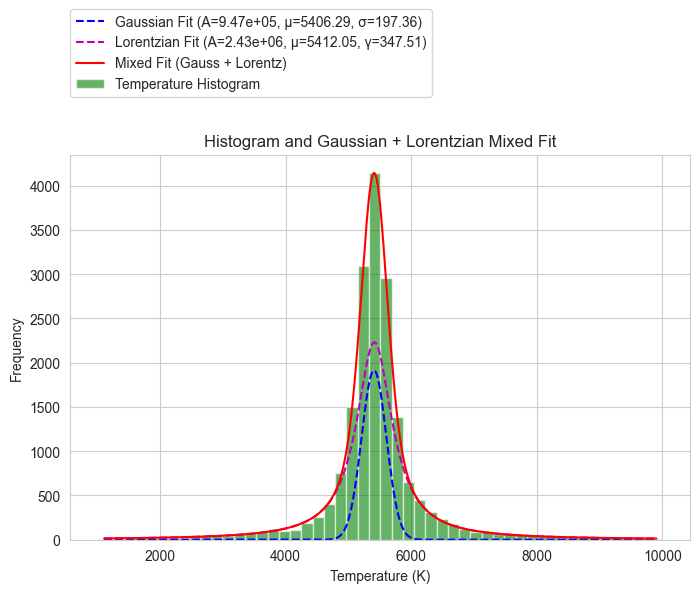

In [44]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm, cauchy

# ヒストグラムを作成（温度データを使用）
hist_values, bin_edges = np.histogram(temperatures, bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ガウシアンとローレンチアンの混合モデルを定義
def mixed_model(x, A1, mu1, sigma1, A2, mu2, gamma2):
    gauss = A1 * norm.pdf(x, mu1, sigma1)
    lorentz = A2 * cauchy.pdf(x, mu2, gamma2)
    return gauss + lorentz

# 初期値を設定してフィッティングを実行
p0 = [max(hist_values), np.mean(temperatures), np.std(temperatures), max(hist_values)/2, np.mean(temperatures)+100, 200]  # 初期値

# 曲線フィッティング
popt, pcov = curve_fit(mixed_model, bin_centers, hist_values, p0=p0)

# フィット結果のパラメータ
A1_fit, mu1_fit, sigma1_fit, A2_fit, mu2_fit, gamma2_fit = popt

# フィットしたモデルを計算
x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
y_fit = mixed_model(x_fit, *popt)

# ガウシアン部分とローレンチアン部分を計算
gauss_fit = A1_fit * norm.pdf(x_fit, mu1_fit, sigma1_fit)
lorentz_fit = A2_fit * cauchy.pdf(x_fit, mu2_fit, gamma2_fit)

# フィット結果を表示
print(f"Gaussian: A1={A1_fit:.2e}, mu1={mu1_fit:.2f}, sigma1={sigma1_fit:.2f}")
print(f"Lorentzian: A2={A2_fit:.2e}, mu2={mu2_fit:.2f}, gamma2={gamma2_fit:.2f}")

# ヒストグラムとガウシアン、ローレンチアン、混合フィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x_fit, gauss_fit, 'b--', label=f'Gaussian Fit (A={A1_fit:.2e}, μ={mu1_fit:.2f}, σ={sigma1_fit:.2f})')
plt.plot(x_fit, lorentz_fit, 'm--', label=f'Lorentzian Fit (A={A2_fit:.2e}, μ={mu2_fit:.2f}, γ={gamma2_fit:.2f})')
plt.plot(x_fit, y_fit, 'r-', label=f'Mixed Fit (Gauss + Lorentz)')

# ラベル・タイトル
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Gaussian + Lorentzian Mixed Fit')
plt.legend(loc=(0, 1.15))
plt.show()



In [45]:
# ガウシアンとローレンチアンの平均値と広がりの重み付き平均を計算
mu_weighted = (A1_fit * mu1_fit + A2_fit * mu2_fit) / (A1_fit + A2_fit)
sigma_weighted = (A1_fit * sigma1_fit + A2_fit * gamma2_fit) / (A1_fit + A2_fit)

# これがとりあえずのゴール。それっぽい値が出る
mu_weighted, sigma_weighted, sigma_weighted/mu_weighted

(np.float64(5410.4410224129515),
 np.float64(305.47688909528256),
 np.float64(0.056460626375896765))

# データセット1に対する一括処理の実装

In [46]:
wavelength_arr.shape

(512,)

In [47]:
up_response = up_1.get_frame_data(frame=0)[0]
down_response = down_1.get_frame_data(frame=0)[0]

up_response.shape, down_response.shape

((512,), (512,))

In [48]:
ref_intensity_interpolated.shape

(512,)

## 校正

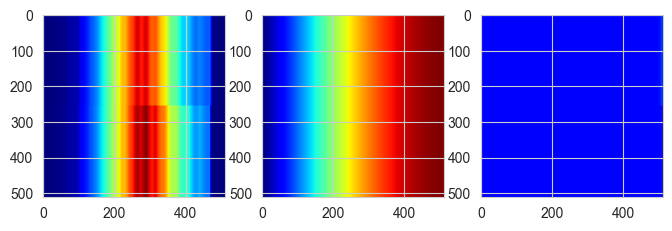

In [90]:
# 校正用の2次元配列を作ってしまう
filter_image = np.zeros((512, 512))
ref_image = np.zeros((512, 512))

# up, downをコピー
# 256は計算される必要がある
filter_image[:256, :] = up_response[:, np.newaxis].T # 256は含まれない。
filter_image[256:, :] = down_response[:, np.newaxis].T

# ref_spectrumを展開
ref_image[:, :] = ref_intensity_interpolated[:, np.newaxis].T

calibration_image = ref_image / filter_image
calibration_image = calibration_image

fig, axes = plt.subplots(1, 3, figsize=(8, 5))
axes[0].imshow(filter_image, cmap='jet')
axes[1].imshow(ref_image, cmap='jet')
axes[2].imshow(calibration_image, cmap='jet')
plt.show()
plt.close()

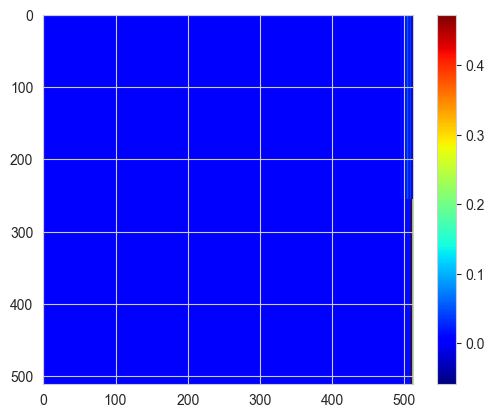

In [91]:
plt.imshow(calibration_image, cmap='jet')
plt.colorbar()
plt.show()
plt.close()

In [73]:
# テストframeを設定
test_frames = [0, 390] # 二要素で固定

In [74]:
# テストframeにおける正解データを取得
if False:
    ans_spectra = []
    
    for frame in test_frames:
        ans_spectra.append(ans_calib_1.get_frame_spectra(frame=frame)['Intensity'].values.reshape((512, 512)))

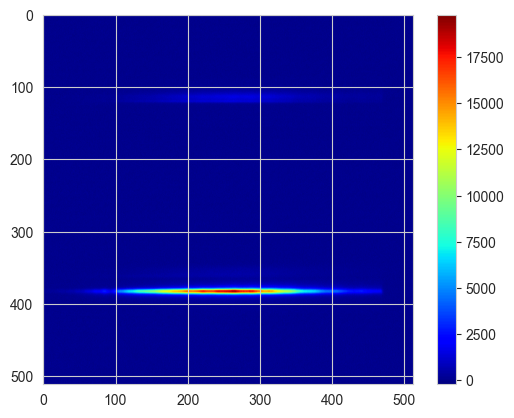

In [99]:
# 補正前を表示
plt.imshow(
    raw_radiation_1.get_frame_data(test_frames[1]),
    cmap='jet'
)
plt.colorbar()
plt.show()
plt.close()



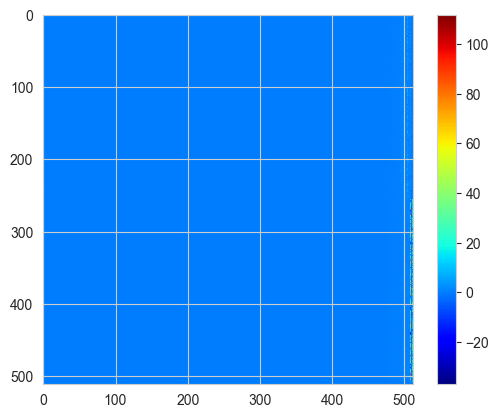

In [98]:
# 補正後を表示
plt.imshow(
    raw_radiation_1.get_frame_data(test_frames[1]) * calibration_image,
    cmap='jet'
)
plt.colorbar()
plt.show()
plt.close()

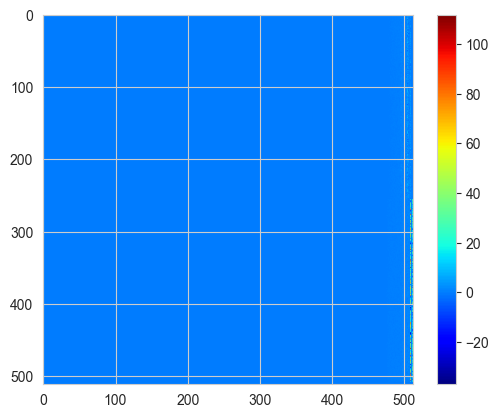

In [94]:
plt.imshow(ans_spectra[1], cmap='jet')
plt.colorbar()

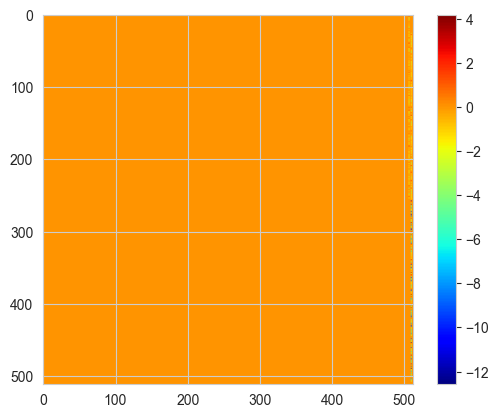

In [97]:
# 差分を表示
plt.imshow(
    raw_radiation_1.get_frame_data(test_frames[1]) * calibration_image - ans_spectra[1],
    cmap='jet'
)
plt.colorbar()
plt.show()
plt.close()

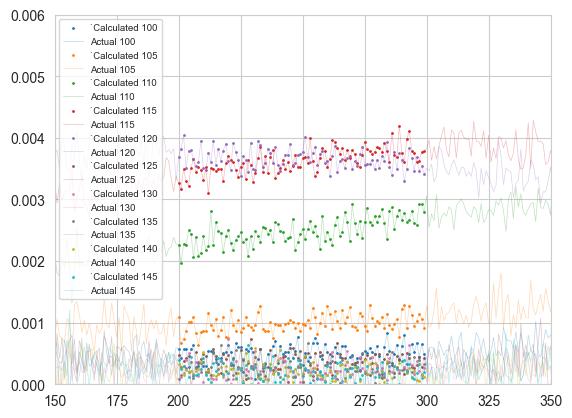

In [130]:
# colormapだと見づらいので、適当な場所をplot
# up
positions = range(100, 150, 5)

calibrated = raw_radiation_1.get_frame_data(test_frames[1]) * calibration_image
ans = ans_spectra[1]

for position in positions:
    plt.scatter(np.arange(200, 300), calibrated[position][200:300], alpha=1, s=1, label=f'`Calculated {position}')
    plt.plot(ans[position], alpha=0.3, lw=0.5, label=f'Actual {position}')
plt.xlim(150, 350)
plt.ylim(0, 0.006)
plt.legend(fontsize='x-small')
plt.show()
plt.close()


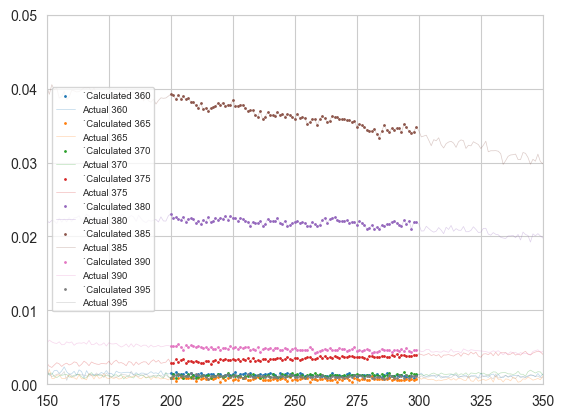

In [131]:
# down
# 薄い線がLightFieldで計算されたもの、点が計算したもの
positions = range(360, 400, 5)

calibrated = raw_radiation_1.get_frame_data(test_frames[1]) * calibration_image 
ans = ans_spectra[1]

for position in positions:
    plt.scatter(np.arange(200, 300), calibrated[position][200:300], alpha=1, s=1, label=f'`Calculated {position}')
    plt.plot(ans[position], alpha=0.3, lw=0.5, label=f'Actual {position}')
plt.xlim(150, 350)
plt.ylim(0, 0.05)
plt.legend(fontsize='x-small')
plt.show()
plt.close()

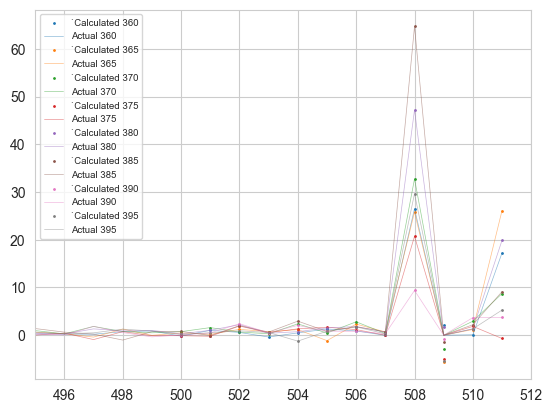

In [134]:
# 端っこを確認
"""
509で一様にずれてる。LightFieldからのcsvの値が0になってる？
それ以外の位置は合ってそう。
なのでimshowでcolorbarが0になりきらなかった。
""" 
# down
# 薄い線がLightFieldで計算されたもの、点が計算したもの
positions = range(360, 400, 5)

calibrated = raw_radiation_1.get_frame_data(test_frames[1]) * calibration_image
ans = ans_spectra[1]

for position in positions:
    plt.scatter(np.arange(500, 512), calibrated[position][500:], alpha=1, s=1, label=f'`Calculated {position}')
    plt.plot(ans[position], alpha=0.5, lw=0.5, label=f'Actual {position}')
plt.xlim(495,512)
plt.legend(fontsize='x-small')
plt.show()
plt.close()


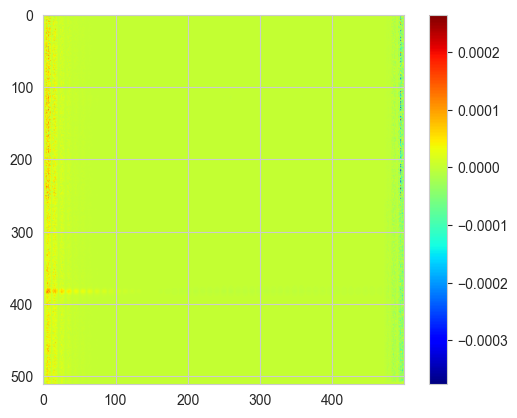

In [135]:
# wavlength_pixel=500までの(509を抜いた)差分を表示
"""
小数点以下5桁目で差が発生。小数処理の差とかだと思うのでOK
"""
plt.imshow(
    calibrated[:, :500] - ans_spectra[1][:, :500],
    cmap='jet'
)
plt.colorbar()
plt.show()
plt.close()


# データセット2でも確認